<a href="https://colab.research.google.com/github/Jaesu26/dacon-temp/blob/main/2023-04-15-%EC%B9%BC%EB%A1%9C%EB%A6%AC-%EC%86%8C%EB%AA%A8%EB%9F%89-%EC%98%88%EC%B8%A1-tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 칼로리 소모량 예측 AI 경진대회

In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 w

## 데이터 불러오기

In [ ]:
import gc
import logging
import os
import random
import warnings
from abc import ABCMeta, abstractmethod
from copy import deepcopy
from glob import glob

import easydict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from numpy.typing import NDArray
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from typing import Any, Dict, List, Optional, Tuple, Union

warnings.filterwarnings("ignore") 

In [ ]:
from google.colab import drive

drive.mount("/content/drive")  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/칼로리-소모량-예측

/content/drive/MyDrive/Colab Notebooks/칼로리-소모량-예측


- 데이터 불러오기

In [ ]:
df = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [ ]:
df.head()

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
0,TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
1,TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
2,TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
3,TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
4,TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


In [ ]:
df.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


In [ ]:
df.isnull().values.any()

False

`-` 결측치는 없다

- ID 제거

In [ ]:
df = df.drop("ID", axis=1)
test = test.drop("ID", axis=1)

- 하이퍼파라미터 

In [ ]:
args = easydict.EasyDict({
    "weights_path": "./weights",
    "num_folds": 5,
    "max_epochs": 300,
    "bs": 128,  # batch size
    "lr": 8e-3,  # learning rate
    "gradient_clip_val": 1.0,
    "seed": 23,
    "log_interval": 10,
})

- 가중치 저장폴더

In [ ]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as e:
        raise OSError(e)

In [ ]:
create_folder(args.weights_path)

## 변수 전처리

In [ ]:
df["Height"] = df.pop("Height(Feet)") * 30.48 + df.pop("Height(Remainder_Inches)") * 2.54
test["Height"] = test.pop("Height(Feet)") * 30.48 + test.pop("Height(Remainder_Inches)") * 2.54

df["Weight"] = df.pop("Weight(lb)") * 0.453592
test["Weight"] = test.pop("Weight(lb)") * 0.453592

df["Body_Temperature"] = (df.pop("Body_Temperature(F)") - 32) / 1.8
test["Body_Temperature"] = (test.pop("Body_Temperature(F)") - 32) / 1.8

In [ ]:
df["Calories_Burned"] = df.pop("Calories_Burned")  # 시각화를 위해 target을 마지막 컬럼으로 이동

## 시각화

In [ ]:
sns.set_theme(style="white")

- 상관계수 행렬

<Axes: >

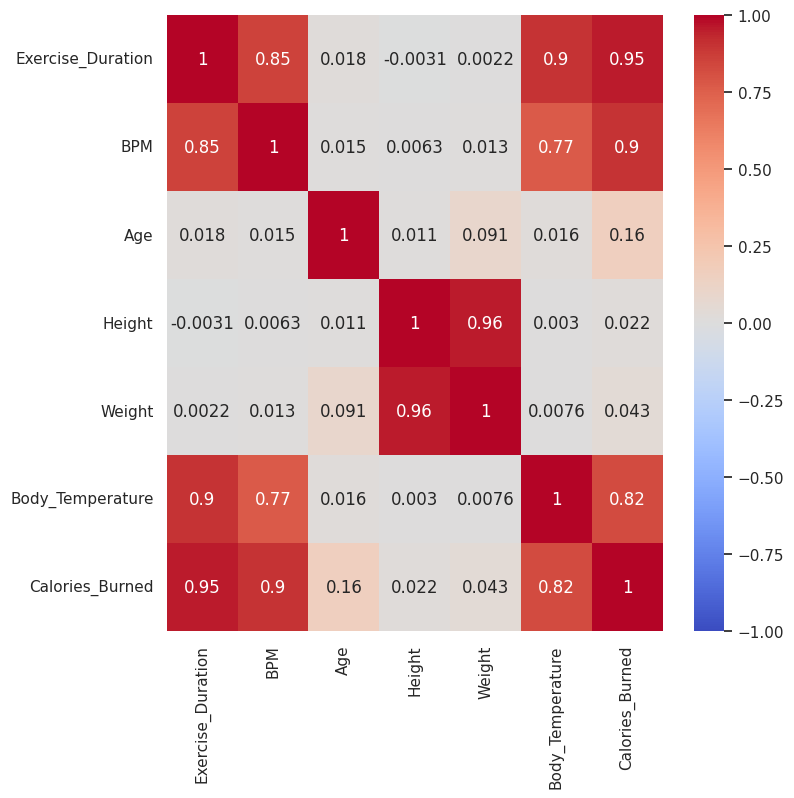

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap="coolwarm")

`-` 운동 시간, 체온, BPM끼리는 강한 양의 상관관계를 가진다

`-` 이들은 또한 칼로리 소모량과도 강한 양의 상관관계를 가진다

`-` 키와 몸무게는 강한 양의 상관관계를 가진다

`-` 키와 몸무게, 칼로리 소모량 사이에는 상관관계가 존재하지 않는다

`-` 칼로리 소모량은 운동의 강도와 운동 시간에 영향을 받을 것이다

`-` 운동 시간은 변수로서 주어졌고 운동의 강도는 BPM과 체온으로 나타낼 수 있을 것이다

`-` 체온과 BPM은 키, 몸무게, 성별, 나이, 체중 상태에 영향을 받는다

- 히스토그램

<Axes: xlabel='Age', ylabel='Count'>

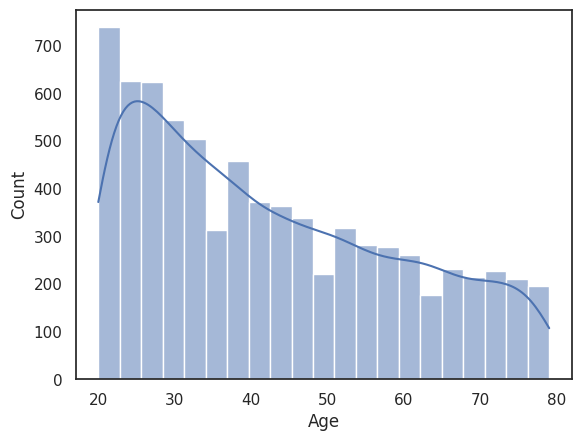

In [ ]:
sns.histplot(data=df, x="Age", kde=True)

<Axes: xlabel='Body_Temperature', ylabel='Count'>

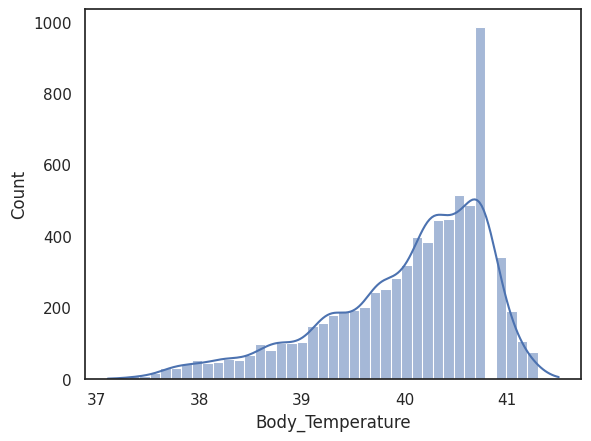

In [ ]:
sns.histplot(data=df, x="Body_Temperature", kde=True)

<Axes: xlabel='Calories_Burned', ylabel='Count'>

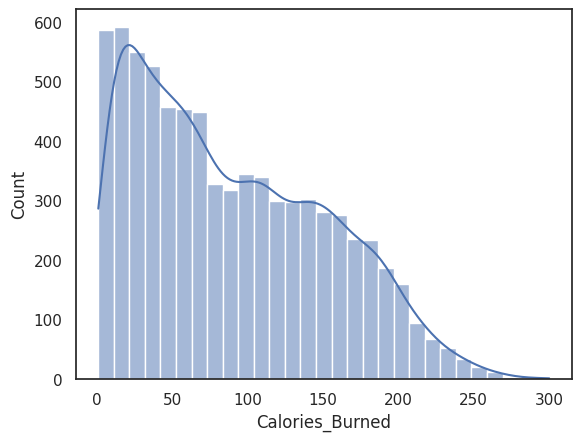

In [ ]:
sns.histplot(data=df, x="Calories_Burned", kde=True)

`-` 나이, 체온, 칼로리 소모량의 분포는 종모양과는 거리가 먼 분포로 적절한 변수변환이 필요하다

<Axes: xlabel='Calories_Burned', ylabel='Count'>

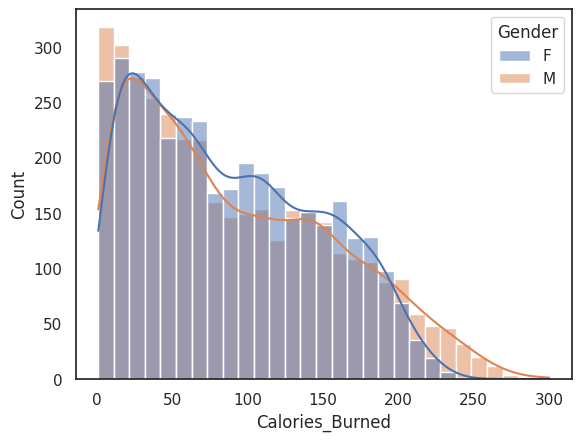

In [ ]:
sns.histplot(data=df, x="Calories_Burned", hue="Gender", kde=True)

`-` 칼로리 소모량은 오른쪽으로 꼬리가 긴 분포이다

`-` 남자가 여자보다 칼로리 소모량의 분산이 더 크다

- 산점도

<Axes: xlabel='Exercise_Duration', ylabel='Calories_Burned'>

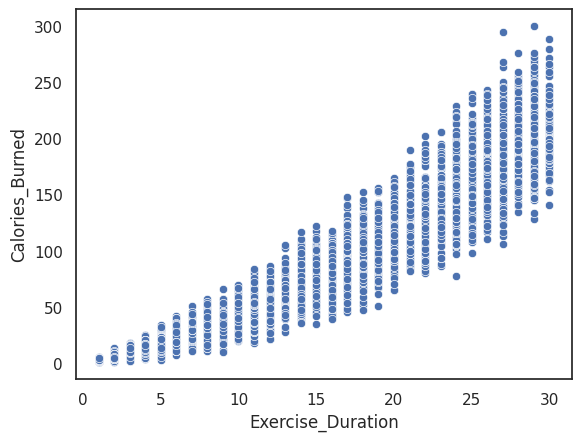

In [ ]:
sns.scatterplot(data=df, x="Exercise_Duration", y="Calories_Burned")

<Axes: xlabel='Exercise_Duration', ylabel='Calories_Burned'>

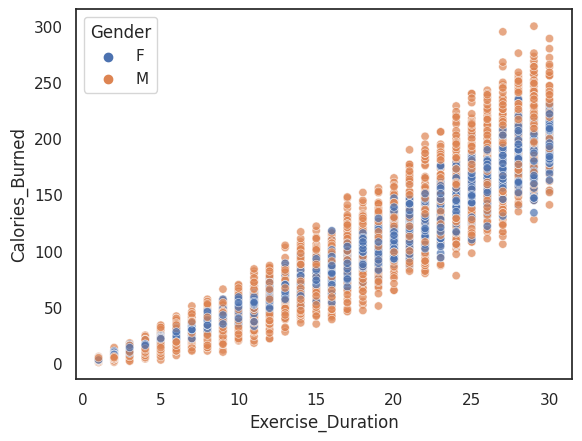

In [ ]:
sns.scatterplot(data=df, x="Exercise_Duration", y="Calories_Burned", hue="Gender", alpha=0.7)

`-` 운동 시간과 칼로리 소모량은 강한 양의 상관관계를 가진다

- 상자 그림

<Axes: xlabel='Weight_Status', ylabel='Calories_Burned'>

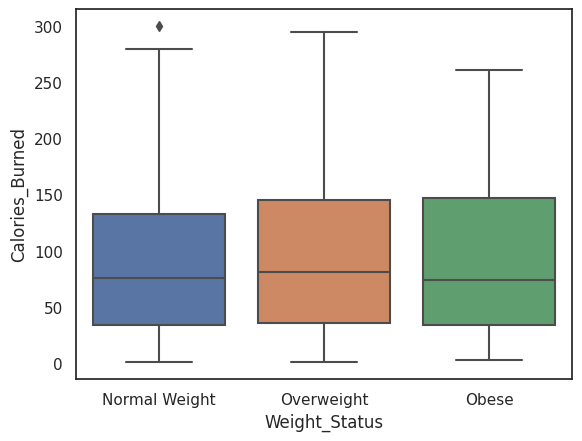

In [ ]:
sns.boxplot(data=df, x="Weight_Status", y="Calories_Burned")

`-` 체중 상태에 따라 평균에는 큰 차이가 없지만 변동성이 다르다

`-` 체중 상태를 더 정밀하게 나타내기 위해 수치형 변수인 BMI로 대체하겠다

## 피처 엔지니어링

In [ ]:
df["BMI"] = df["Weight"] / (df["Height"] / 100)**2
test["BMI"] = test["Weight"] / (test["Height"] / 100)**2

df = df.drop("Weight_Status", axis=1)
test = test.drop("Weight_Status", axis=1)

df["Gender"] = df["Gender"].map({"F": 0, "M": 1})
test["Gender"] = test["Gender"].map({"F": 0, "M": 1})

In [ ]:
df["Calories_Burned"] = np.log1p(df["Calories_Burned"])

df["Age"] = np.log(df["Age"])
test["Age"] = np.log(test["Age"])

body_temp_mean = df["Body_Temperature"].mean()
body_temp_std = df["Body_Temperature"].std()
df["Body_Temperature"] = (((df["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3
test["Body_Temperature"] = (((test["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3

## 모델 학습 준비

In [94]:
import torch.optim as optim
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

- 양적 변수 스케일링

In [ ]:
numeric_columns = df.columns[df.dtypes == np.float]
target_column = "Calories_Burned"

In [ ]:
# target
minmax_scaler = MinMaxScaler()  
df[target_column] = minmax_scaler.fit_transform(df[[target_column]])

# target외의 양적 변수
tmp_scaler = MinMaxScaler()
df[numeric_columns.drop(target_column)] = tmp_scaler.fit_transform(df[numeric_columns.drop(target_column)])
test[numeric_columns.drop(target_column)] = tmp_scaler.transform(test[numeric_columns.drop(target_column)])

In [ ]:
df.head()

,Exercise_Duration,BPM,Gender,Age,Height,Weight,Body_Temperature,Calories_Burned,BMI
0,26.0,107.0,0,45,175.26,69.989246,40.888889,166.0,22.785874
1,7.0,88.0,1,50,198.12,102.012841,39.611111,33.0,25.989517
2,7.0,86.0,1,29,190.50,99.019134,39.611111,23.0,27.285327
3,17.0,99.0,0,33,167.64,66.995538,40.000000,91.0,23.839140
4,9.0,88.0,1,38,177.80,77.019922,39.277778,32.0,24.363493


## 모델 교차검증 및 예측

In [125]:
from sklearn.model_selection import KFold

In [155]:
y = df.pop("Calories_Burned").values.reshape(-1, 1)
X = df.values

In [131]:
X_test = test.values

In [128]:
cat_idxs = [2]
cat_dims = [2]
cat_emb_dim = [1]
kfold = KFold(n_splits=args.num_folds, shuffle=True, random_state=args.seed)

In [129]:
tabnet = TabNetRegressor(
    n_d=16, n_a=16, n_steps=3,
    optimizer_fn=optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, 
                      "gamma":0.9},
    scheduler_fn=optim.lr_scheduler.StepLR,
    mask_type='entmax',
    cat_dims=cat_dims, 
    cat_emb_dim=cat_emb_dim, 
    cat_idxs=cat_idxs,
    verbose=10,
    device_name='cpu',
)

In [133]:
preds_list = []
for i, (train_indices, valid_indices) in enumerate(kfold.split(X)):
    print(f'[{i + 1} / 5] Fold Training......')
    X_train, y_train = X[train_indices], y[train_indices]
    X_valid, y_valid = X[valid_indices], y[valid_indices]
    tabnet.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name=['valid'],
        eval_metric=['rmse'],
        max_epochs=300,
        patience=50,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    ) 
    preds = tabnet.predict(X_test)
    preds_list.append(preds)

[1 / 5] Fold Training......
epoch 0  | loss: 11739.65814| valid_rmse: 111.22625|  0:00:01s
epoch 10 | loss: 131.08633| valid_rmse: 386.47438|  0:00:06s
epoch 20 | loss: 32.46555| valid_rmse: 133.95754|  0:00:10s
epoch 30 | loss: 33.66124| valid_rmse: 57.55243|  0:00:13s
epoch 40 | loss: 29.41471| valid_rmse: 31.03637|  0:00:18s
epoch 50 | loss: 23.18241| valid_rmse: 17.59424|  0:00:22s
epoch 60 | loss: 24.09619| valid_rmse: 8.57655 |  0:00:26s
epoch 70 | loss: 19.85877| valid_rmse: 4.80799 |  0:00:30s
epoch 80 | loss: 19.33302| valid_rmse: 2.08487 |  0:00:35s
epoch 90 | loss: 18.01322| valid_rmse: 3.5487  |  0:00:39s
epoch 100| loss: 17.61396| valid_rmse: 2.34053 |  0:00:43s
epoch 110| loss: 15.02959| valid_rmse: 1.26602 |  0:00:47s
epoch 120| loss: 12.98827| valid_rmse: 1.18899 |  0:00:52s
epoch 130| loss: 13.34555| valid_rmse: 2.8838  |  0:00:56s
epoch 140| loss: 11.64922| valid_rmse: 1.88774 |  0:00:59s
epoch 150| loss: 15.4351 | valid_rmse: 2.37974 |  0:01:03s
epoch 160| loss: 13.6

- Test 예측

In [153]:
submission[target_column] = np.array(preds_list).mean(0)
submission.to_csv('./data/submission-tabnet-5fold.csv', index=False)